In [21]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b2
import torchvision.transforms as transforms

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2


import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

from tqdm import tqdm
import copy
import os
import shutil

default_path = 'E:/2025_KMITL/CODING/SAIG_AI_2/competition'


In [ ]:
print(pd.read_csv('../train.csv')['style'].value_counts())

## FOLDER THING

In [ ]:
####MOVE UNLABELED IMAGE FROM ALL IMAGE FOLDER TO TEST FOLDER

def move_test_image():
    
    image_path = os.path.join(default_path,'train')
    image_des_path = os.path.join(default_path,'test')
    
    df_uuid = pd.read_csv(os.path.join(default_path, 'sample_submission.csv'))['uuid'] + '.png'
    all_image_file = os.listdir(image_path)
    
    unlabel_file = [i for i in df_uuid if i in all_image_file]
    
    for j in unlabel_file:
        shutil.move(os.path.join(image_path, j), os.path.join(image_des_path, j))
    
    

move_test_image()
    

In [ ]:
##CHECK FILE
len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/train')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/test'))

In [ ]:
def split_valid_train(csv_path):
    
    #FILE THINGS
    train_path = os.path.join(default_path, 'train')
    File = pd.read_csv(os.path.join(default_path, csv_path))
    size = 0.2 #20 persent from train folder
    
    os.makedirs(os.path.join(default_path, 'valid'), exist_ok=True)
    valid_path = os.path.join(default_path, 'valid')
    
    train_df, valid_df = train_test_split(File, test_size=size, stratify=File['style'], random_state=42)
    
    valid_imgs = [v + '.png' for v in valid_df['uuid']]
    
    train_df.to_csv('../train.csv', index=False)
    valid_df.to_csv('../valid.csv', index=False)
    
    for i in tqdm(valid_imgs, desc="Moving valid images"):
        if os.path.exists(os.path.join(train_path, i)):
            shutil.move(os.path.join(train_path, i), os.path.join(valid_path, i))    
        else:
            print('nah')

split_valid_train('train.csv')
              

In [ ]:
##CHECK FILE
len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/train')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/valid')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/test'))

# IMAGE DATASET

## IMAGE DATASET DEF

In [53]:


class ImageDataset(Dataset):
    def __init__(self, data_dir, csv_path, transform=None, has_labels = True):
        self.data_dir = data_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.has_labels = has_labels
        
        self.labels_dic = { 'Ink scenery'   : 0,
                         'comic'            : 1,
                         'cyberpunk'        : 2,
                         'futuristic UI'    : 3,
                         'lowpoly'          : 4,
                         'oil painting'     : 5,
                         'pixel'            : 6,
                         'realistic'        : 7,
                         'steampunk'        : 8,
                         'water color'      : 9,
                         'UNK'              : 10
                         }
        
            
        
    def __len__(self):
        return len(self.df['uuid'])

    def __getitem__(self, idx):
        uuid = self.df.loc[idx, 'uuid']
        image_path = os.path.join(self.data_dir, uuid + '.png')
        # image = Image.open(image_path).convert('RGB')
        image = np.array(Image.open(image_path).convert('RGB'))

    # PIL → NumPy → Albumentations → Tensor
        if self.transform:
            # image = self.transform(image)
            image = self.transform(image=image)['image']

        if self.has_labels:
            style = self.df.loc[idx, 'style']
            if pd.isna(style):
                raise ValueError(f"Missing label at index {idx}")
            label = self.labels_dic[style]
            return image, label
        else:
            return image, uuid
    
    

In [54]:
######################################## TEST ZONE FOR DATASET FUNC #######################
train_dataset = ImageDataset('../train', '../train.csv',has_labels= True)
valid_dataset = ImageDataset('../valid', '../valid.csv',has_labels= True)
test_dataset = ImageDataset('../test', '../sub_dir/submission01.csv', has_labels=False)

In [4]:
len(valid_dataset)

1306

In [ ]:
image , label = valid_dataset[1305]
print(label)
image  

In [55]:

#
means = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform_train = A.Compose([
    A.Resize(288, 288),
    A.CenterCrop(288, 288),
    A.HorizontalFlip(p=0.5),
    A.ImageCompression(
        quality_range=(50, 100),         
        compression_type='jpeg',   
        p=0.4
    ),
    A.OneOf([
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.MotionBlur(blur_limit=5, p=0.2),
    ], p=0.3),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
    ], p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=means, std=std),
    ToTensorV2()
])


transform_normal = A.Compose([
    A.Resize(288, 288),
    A.CenterCrop(288, 288),
    A.Normalize(mean=means, std=std),
    ToTensorV2()
])

# transform_train = transforms.Compose([transforms.Resize(288),
#                                     transforms.CenterCrop(288),
#                                     transforms.RandomHorizontalFlip(p = 0.5),
#                                     transforms.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue= 0.02),
#                                     transforms.RandomRotation(degrees = 10),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean= means, std=std)])


# transform_normal = transforms.Compose([transforms.Resize(288),
#                                     transforms.CenterCrop(288),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean= means, std=std)])


train_dataset = ImageDataset('../train', '../train.csv', transform=transform_train, has_labels = True)
valid_dataset = ImageDataset('../valid', '../valid.csv', transform=transform_normal, has_labels = True)
test_dataset = ImageDataset('../test', '../sub_dir/submission01.csv', transform=transform_normal, has_labels = False)


In [6]:
################################ TEST DATASET AFTER TRANSFORM TO TENSOR IMAGE #####################
image, label = train_dataset[0]
print(label)
image

7


tensor([[[ 1.0673,  1.0673,  1.0673,  ..., -1.1932, -1.2103, -1.2103],
         [ 1.0673,  1.0673,  1.0673,  ..., -1.1932, -1.2103, -1.2103],
         [ 1.0673,  1.0673,  1.0673,  ..., -1.1589, -1.1932, -1.2103],
         ...,
         [-2.0665, -2.0665, -2.0837,  ...,  1.6667,  1.6495,  1.6324],
         [-2.0665, -2.0665, -2.0665,  ...,  1.6495,  1.6324,  1.6324],
         [-2.0494, -2.0665, -2.0665,  ...,  1.6495,  1.6324,  1.6153]],

        [[ 1.7633,  1.7633,  1.7633,  ...,  0.3102,  0.2927,  0.2927],
         [ 1.7633,  1.7633,  1.7633,  ...,  0.3277,  0.3102,  0.2927],
         [ 1.7808,  1.7808,  1.7633,  ...,  0.3452,  0.3277,  0.3102],
         ...,
         [-1.8081, -1.7906, -1.7906,  ...,  1.8158,  1.8158,  1.7808],
         [-1.7906, -1.7906, -1.7906,  ...,  1.8158,  1.7808,  1.7808],
         [-1.7906, -1.7906, -1.7906,  ...,  1.7983,  1.7808,  1.7458]],

        [[ 2.3611,  2.3611,  2.3437,  ...,  1.5071,  1.4897,  1.4722],
         [ 2.3611,  2.3611,  2.3437,  ...,  1

In [56]:
#LOAD DATA STUFF

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## THIS SET FOR TEST

In [8]:
for images, labels in tqdm(train_loader, desc="Loading Train Data"):
    break 

Loading Train Data:   0%|          | 0/162 [00:00<?, ?it/s]


In [9]:
images.shape, labels.shape, labels

(torch.Size([32, 3, 288, 288]),
 torch.Size([32]),
 tensor([8, 0, 9, 7, 5, 7, 9, 3, 4, 5, 0, 7, 8, 0, 9, 3, 6, 9, 0, 3, 3, 9, 3, 4,
         2, 5, 6, 9, 7, 0, 8, 2]))

In [10]:
for images, labels in train_loader:
    print(labels.unique())
    break

tensor([0, 3, 4, 5, 6, 7, 8, 9])


# TRAINNG LOOP

In [11]:
model = efficientnet_b2(weights='DEFAULT')
# model.classifier[1] =nn.Linear(in_features=512, out_features=11)
model.classifier[1] = nn.Linear(in_features=1408, out_features=10)
print(str(model))


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
####### CHECK ##########
######## IMAGE FORM DATALOADER ######
example = model(images)
example.shape

torch.Size([32, 10])

###### ###### TRAINING LOOP ###### ###### ❤️❤️❤️❤️❤️❤️❤️❤️❤️ SAIG ❤️❤️❤️❤️❤️❤️

MOBILENET_V2
##epcoh =5 ##
##Epoch 5/5 - Train loss: 0.3678677924861575, Validation loss: 0.47692899825950386##

NEST ซักอย่าง ลืม

In [13]:
##################### CHECK CUDA IN DEVICE ################3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, ignore_index=10, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, inputs, targets):
        # cross-entropy แบบไม่ reduce เพื่อคำนวณ pt
        ce = F.cross_entropy(
            inputs, targets,
            weight=self.alpha,
            ignore_index=self.ignore_index,
            reduction='none'
        )
        pt = torch.exp(-ce)
        loss = (1 - pt) ** self.gamma * ce

        # mask out ignored targets
        mask = (targets != self.ignore_index)
        loss = loss * mask.float()

        if self.reduction == 'mean':
            return loss.sum() / mask.sum().clamp(min=1)
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [15]:
counts = torch.tensor([875,869,753,684,557,473,376,290,193,106], dtype=torch.float32, device=device)
alpha = (counts.sum() / (len(counts) * counts))
alpha = alpha / alpha.sum()

criterion = FocalLoss(alpha=alpha, gamma=2.0, ignore_index=10)
# criterion = nn.CrossEntropyLoss(ignore_index=10)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [25]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [31]:
class EarlyStoppingF1:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = float('-inf')
        self.early_stop = False

    def __call__(self, current_score):
        # ถ้ายังไม่เคยตั้ง best_score ให้เซ็ตครั้งแรก
        if self.best_score == float('-inf'):
            self.best_score = current_score
            return

        # ถ้า score ไม่ดีขึ้นเกิน min_delta ให้ counter เพิ่ม
        if current_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # ถ้า score ดีขึ้น ให้รีเซ็ต counter และอัปเดต best_score
            self.best_score = current_score
            self.counter = 0

In [35]:
# --- BEFORE the loop ---
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast, GradScaler
num_epochs = 20
patience   = 3
min_delta  = 1e-4
best_f1    = float('-inf')
counter    = 0
best_epoch = 0
best_model_wts = copy.deepcopy(model.state_dict())

# Scheduler, scaler, etc. as before…
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,
    anneal_strategy='cos'
)
scaler = GradScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    ####### Training #######
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(images)
            loss    = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    ####### Validation #######
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Valid"):
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss    = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            probs    = F.softmax(outputs, dim=1)
            confs, p0 = torch.max(probs, dim=1)
            preds    = torch.where(confs < 0.6,
                                   torch.tensor(10, device=device),
                                   p0)
            all_preds .extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(valid_loader.dataset)
    val_f1   = f1_score(all_labels, all_preds,
                        average='macro',
                        labels=list(range(11)))

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val F1: {val_f1:.4f}")

    # --- Early stopping on F1 ---
    if val_f1 > best_f1 + min_delta:
        best_f1        = val_f1
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())
        counter        = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. "
                  f"Best F1: {best_f1:.4f} (epoch {best_epoch})")
            break

# Load best weights
model.load_state_dict(best_model_wts)
print(f"Loaded best model from epoch {best_epoch} with F1 = {best_f1:.4f}")


Valid: 100%|██████████| 41/41 [00:11<00:00,  3.56it/s]


Epoch 1/20 — Train Loss: 0.0005, Val Loss: 0.0027, Val F1: 0.6553


Valid: 100%|██████████| 41/41 [00:11<00:00,  3.51it/s]


Epoch 2/20 — Train Loss: 0.0004, Val Loss: 0.0275, Val F1: 0.6783


Valid: 100%|██████████| 41/41 [00:11<00:00,  3.60it/s]


Epoch 3/20 — Train Loss: 0.0006, Val Loss: 0.0021, Val F1: 0.6566


Valid: 100%|██████████| 41/41 [00:11<00:00,  3.60it/s]


Epoch 4/20 — Train Loss: 0.0012, Val Loss: 0.0019, Val F1: 0.5167


Valid: 100%|██████████| 41/41 [00:11<00:00,  3.49it/s]

Epoch 5/20 — Train Loss: 0.0023, Val Loss: 0.0016, Val F1: 0.5825
Early stopping at epoch 5. Best F1: 0.6783 (epoch 2)
Loaded best model from epoch 2 with F1 = 0.6783


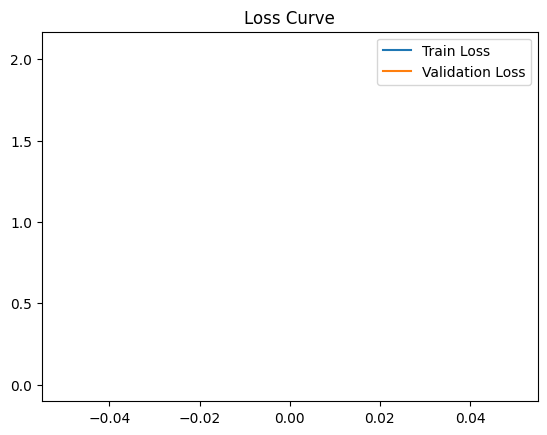

In [39]:
plt.plot(running_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'efficientnet_b2_w_uv.pth')

# reloading

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_loss,
    'val_losses': val_loss,
}, 'checkpoint.pth')
print("Checkpoint saved!")

In [ ]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

start_epoch = checkpoint['epoch'] + 1
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

In [ ]:
model.to(device)
num_epochs = 8
early_stopping = EarlyStopping(patience=3)
best_model_wts = copy.deepcopy(model.state_dict())
train_losses, val_losses = [], []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)
# เทรนต่อจาก epoch ที่โหลด
for epoch in range(start_epoch, num_epochs):

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    val_f1 = f1_score(all_labels, all_preds, average='macro', labels=list(range(11)))
    
    #for man mai dee kin 
    scheduler.step(val_loss)
    
    print("Prediction counts:", Counter(all_preds))
    print("True label counts:", Counter(all_labels))

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}, F1 Score: {val_f1}")
    
    if val_loss < early_stopping.best_loss:
        best_model_wts = copy.deepcopy(model.state_dict())
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping!")
        break

# test predict


In [40]:
def predict_with_threshold(model, dataloader, threshold=0.6, return_conf=False):
    model.eval()
    predictions = []
    confidences = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Predicting"):
            if isinstance(images, (list, tuple)):
                images = images[0]
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)
            for conf, pred in zip(confs, preds):
                if conf.item() < threshold:
                    predictions.append(10)
                else:
                    predictions.append(pred.item())
                if return_conf:
                    confidences.append(conf.item())
    if return_conf:
        return predictions, confidences
    return predictions

In [41]:
def get_all_labels(dataloader):
    all_labels = []
    for batch in tqdm(dataloader, desc="data loader"):
        if isinstance(batch, (list, tuple)):
            _, labels = batch
        else:
            continue  # เผื่อ dataloader ไม่มี label
        all_labels.extend(labels.cpu().numpy())
    return all_labels

y_true = get_all_labels(valid_loader)

data loader: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]


In [49]:
model.load_state_dict(best_model_wts) #load best model

<All keys matched successfully>

In [50]:

# 1) เก็บความมั่นใจ (confs) กับดัชนี prediction (preds0) และ label จริง (labels)
all_confs, all_preds0, all_labels = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        probs  = torch.softmax(logits, dim=1)
        confs, preds0 = probs.max(dim=1)

        all_confs .extend(confs.cpu().numpy())
        all_preds0.extend(preds0.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_confs   = np.array(all_confs)    # shape [N_valid]
all_preds0  = np.array(all_preds0)   # shape [N_valid]
all_labels  = np.array(all_labels)   # shape [N_valid]

# 2) ลอง threshold ตั้งแต่ 0.0–1.0 ทีละ 0.01
best_thr, best_f1 = 0.0, 0.0
for thr in np.linspace(0.0, 1.0, 101):
    # map ค่าที่ conf < thr ให้เป็น UNK (index 10)
    preds = np.where(all_confs < thr, 10, all_preds0)

    # คำนวณ macro-F1 (labels 0–10 รวม UNK ด้วย)
    f1 = f1_score(all_labels, preds, average='macro', labels=list(range(11)))

    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"Best threshold = {best_thr:.2f}, Val macro-F1 = {best_f1:.4f}")


Best threshold = 0.32, Val macro-F1 = 0.7269


In [ ]:
best_threshold = 0.45

my_dict = {0: 'Ink scenery',
           1: 'comic',
           2: 'cyberpunk',
           3: 'futuristic UI',
           4: 'lowpoly',
           5: 'oil painting',
           6: 'pixel',
           7: 'realistic',
           8: 'steampunk',
           9: 'water color',
           10: 'UNK'}

# 4. รัน inference บน test_loader
uuid_list, pred_list = [], []
with torch.no_grad():
    for images, uuids in test_loader:     
        images = images.to(device)
        probs  = model(images).softmax(1) # [B,10]
        confs, preds0 = probs.max(dim=1) # confidence + index 0–9

        # map low‐conf → UNK (10)
        preds = torch.where(
            confs < best_threshold,
            torch.full_like(preds0, 10),
            preds0
        )

        # เก็บ uuid กับชื่อสไตล์
        uuid_list.extend(uuids)                      # ถ้า loader คืน uuid
        pred_list.extend([my_dict[i.item()] for i in preds])

# 5. เซฟ submission.csv
import pandas as pd
df_sub = pd.DataFrame({'uuid': uuid_list, 'style': pred_list})
df_sub.to_csv('../sub_dir/submission_b2_3.csv', index=False)


In [ ]:
preds_test = predict_with_threshold(model, test_loader, threshold = 0.)

Predicting: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]


In [ ]:
# for temp in [2.5, 3.0, 3.5, 4.0]:
#     for t in [1.7, 2.0, 2.3, 2.5]:
#         preds = predict_with_entropy_threshold(model, test_loader, threshold=t, temperature=temp)
#         unknown_count = sum(1 for label in preds if label == 10)
#         print(f"Temp={temp}, Threshold={t} → Unknown count: {unknown_count}")

In [48]:
unknown_count = sum(1 for label in preds_test if label == 10)
print(unknown_count)

8


In [45]:
df = pd.read_csv("../sub_dir/submission01.csv") 
df["style"] = preds_test
df.to_csv("../sub_dir/submission_b2_1.csv", index=False)

water color


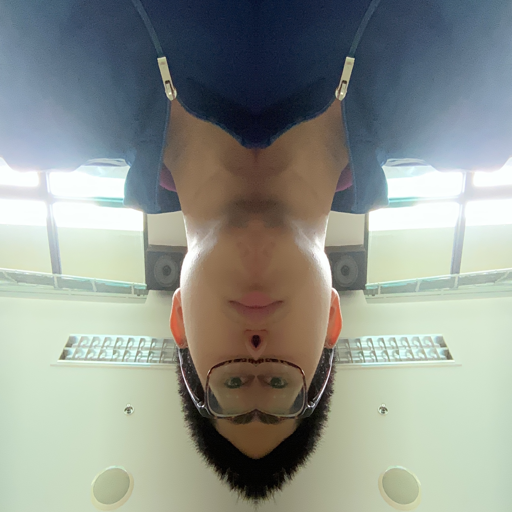

In [ ]:


def checktest(idx, img_dir, csv_path, dict):
    df_read = pd.read_csv(csv_path)
    uuid = df_read.loc[idx, 'uuid']
    img_path = os.path.join(img_dir, uuid + '.png')
    img = Image.open(img_path).convert('RGB')
    style = dict[df_read.loc[idx, 'style']]
    return img, style

img, label = checktest(1410, '../test', '../sub_dir/submission_b2_1.csv', my_dict)
print(label)
img

In [ ]:
def label_to_style(csvfile):
    df = pd.read_csv(csvfile)
    df['style'] = df['style'].map(my_dict)
    Name = csvfile
    df.to_csv(Name, index=False)

label_to_style('../sub_dir/submission_b2_1.csv')

In [ ]:
uuid_unk = [i.removesuffix('.png') for i in os.listdir('../bla')] 


uuid_unk